# Tutorial 2: Fast Diffusion
A big challeng in diffusion models, is the cost of inference. Due to the multi-step generation, the inference is costly but also grants us more flexibility. DDPMs ofter requires too many time steps than is reasonable.

In order to address this problem, we can apply DDIM to skip some sampling steps e.g., from step 10 directly to step 20 (sample the hidden variable of step 20 in condition with the sampled hidden variable of step 10) rather than go through 11, 12 ..., 19, 20. DDIM uses a deterministic reverse process unlike DDPM's stochastic reverse process. This gives us analytic functions for multiple time steps, while retaining sufficient image quality. 

# 2A: DDIM
DDIM is not a training method. It is a new sampling method rather than a new diffusion model. Therefore, when we apply DDIM, we can use DDPM to train the model then use DDIM to do the inference.

c:\Users\gertl\Repos\MSGAI24\.venv\Lib\site-packages\diffusers\configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\gertl\Repos\MSGAI24\.venv\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


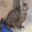

In [4]:
from diffusers import DDIMPipeline, DDIMScheduler, UNet2DModel
from IPython.display import display
import torch

# google/ddpm-cifar10    google/ddpm-church-256
repo_id = "google/ddpm-cifar10"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loading a pretrained unet
unet = UNet2DModel.from_pretrained(repo_id).to(device)
# loading the corresponding training configuration
scheduler = DDIMScheduler.from_config(repo_id)

ddim_pipe = DDIMPipeline(unet, scheduler).to(device)


res = ddim_pipe(num_inference_steps=50)
image = res.images[0]

display(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

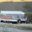

In [5]:
res = ddim_pipe(num_inference_steps=1000)
image = res.images[0]
display(image)

  0%|          | 0/100 [00:00<?, ?it/s]

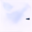

In [6]:
res = ddim_pipe(num_inference_steps=100)
image = res.images[0]
display(image)

  0%|          | 0/10 [00:00<?, ?it/s]

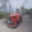

In [7]:
res = ddim_pipe(num_inference_steps=10)
image = res.images[0]
display(image)

  0%|          | 0/2 [00:00<?, ?it/s]

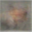

In [8]:
res = ddim_pipe(num_inference_steps=2)
image = res.images[0]
display(image)

There should be a trade-off between sampling steps and image quality.

For DDIM, we can visualize the full sampling stages using the following code.

torch.Size([1, 3, 32, 32])


'Image at step 10'

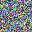

'Image at step 20'

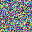

'Image at step 30'

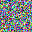

'Image at step 40'

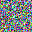

'Image at step 50'

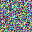

'Image at step 60'

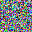

'Image at step 70'

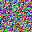

'Image at step 80'

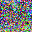

'Image at step 90'

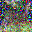

'Image at step 100'

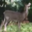

In [9]:
import PIL.Image
import numpy as np
import torch

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

noisy_sample=torch.randn(1, unet.config.in_channels, unet.config.sample_size,
                         unet.config.sample_size)

unet = unet.to(device)
noisy_sample = noisy_sample.to(device)

print(noisy_sample.shape)

scheduler.set_timesteps(100)
sample=noisy_sample

for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        residual=unet(sample,t).sample

    sample =scheduler.step(residual, t, sample).prev_sample

    if (i+1)%10==0:
        display_sample(sample, i+1)

DDIM is also applied on latent diffusion models, LDMs. We can choose the sampling steps of the inference of a LDM.


vqvae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\gertl\.cache\huggingface\hub\models--CompVis--ldm-text2im-large-256\snapshots\30de525ca11a880baea4962827fb6cb0bb268955\vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None} were p

  0%|          | 0/200 [00:00<?, ?it/s]

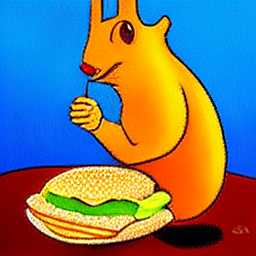

In [11]:
from diffusers import DiffusionPipeline
from IPython.display import display

ldm = DiffusionPipeline.from_pretrained("CompVis/ldm-text2im-large-256").to(device=device)
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=200, eta=0.3, guidance_scale=6).images

display(images[0])

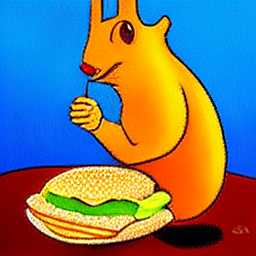

  0%|          | 0/20 [00:00<?, ?it/s]

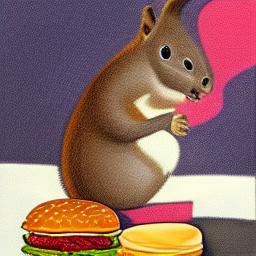

In [12]:
display(images[0])
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=20, eta=0.3, guidance_scale=6).images
display(images[0])

  0%|          | 0/5 [00:00<?, ?it/s]

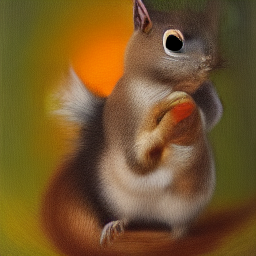

In [13]:
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=5, eta=0.3, guidance_scale=6).images

display(images[0])

In [ ]:
from IPython.display import display, clear_output
from diffusers import UNet2DConditionModel, DDIMScheduler, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
from PIL import Image

dtype = torch.float16 if torch.cuda.is_available() else torch.float32
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype).to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=dtype).to(device)

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual prompt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].to(dtype)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)

def prompt_2_img(prompts, g=7.5, seed=100, steps=20, dim=512, save_int=True, scale_down=8):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to(device=device, dtype=dtype) * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    
    # Calculate initial latents norm
    initial_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    
    # Iterating through defined steps with enhanced progress bar
    pbar = tqdm(scheduler.timesteps, desc=f"Generating (init_norm: {initial_norm:.2f})")
    for i, ts in enumerate(pbar):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Calculate current latents norm and update progress bar
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        pbar.set_postfix({
            'step': f"{i+1}/{steps}",
            'norm': f"{latents_norm:.2f}",
            'timestep': f"{ts.item():.0f}"
        })

        if save_int and i%10==0:
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

In [ ]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=8)
for img in images:
    display(img)

C:\Users\gertl\AppData\Local\Temp\ipykernel_18328\4194767086.py:55: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))


Processing text prompts: ['A dog wearing a hat']


Generating (init_norm: 128.50):  30%|███       | 6/20 [00:29<01:09,  5.00s/it, step=6/20, norm=128.50, timestep=700]

Processing text prompts: ['A dog wearing a hat']
Visualizing initial latents...
Initial Latents Norm: 63.46875


<ipython-input-29-a0017c0c3287>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 64.25
Step 2/70 Latents Norm: 66.6875
Step 3/70 Latents Norm: 65.375
Step 4/70 Latents Norm: 64.5625
Step 5/70 Latents Norm: 75.875
Step 6/70 Latents Norm: 69.4375
Step 7/70 Latents Norm: 66.6875
Step 8/70 Latents Norm: 65.125
Step 9/70 Latents Norm: 64.8125
Step 10/70 Latents Norm: 63.59375
Step 11/70 Latents Norm: 67.8125
Step 12/70 Latents Norm: 66.5
Step 13/70 Latents Norm: 65.25
Step 14/70 Latents Norm: 66.5625
Step 15/70 Latents Norm: 65.5625
Step 16/70 Latents Norm: 63.0
Step 17/70 Latents Norm: 74.6875
Step 18/70 Latents Norm: 70.875
Step 19/70 Latents Norm: 69.75
Step 20/70 Latents Norm: 68.375
Step 21/70 Latents Norm: 66.5625
Step 22/70 Latents Norm: 75.5
Step 23/70 Latents Norm: 70.3125
Step 24/70 Latents Norm: 68.125
Step 25/70 Latents Norm: 72.8125
Step 26/70 Latents Norm: 68.9375
Step 27/70 Latents Norm: 72.6875
Step 28/70 Latents Norm: 70.0
Step 29/70 Latents Norm: 75.5625
Step 30/70 Latents Norm: 69.75
Step 31/70 Latents Norm: 65.4375
Step 32/70 

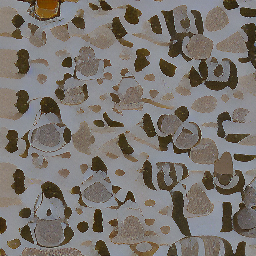

In [32]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=16)
for img in images:
    display(img)